# libraries

In [21]:
import requests
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import string
import nltk
sns.set() # overwrite matplotlib
from bs4 import BeautifulSoup
from PIL import Image, ImageDraw, ImageFilter
from collections import defaultdict,Counter
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.stem import WordNetLemmatizer
# nltk.download("wordnet") # run once
# nltk.download("omw-1.4") # run once

# Obtaining the Script
The script for the movie Avengers: Endgame was retrieved from the IMSDB website using the requests module and then parsed with Beautiful Soup 4.

In [2]:
url = 'https://imsdb.com/scripts/Avengers-Endgame.html'
response = requests.get(url) # obtaining the movie script
soup = BeautifulSoup(response.content, 'html.parser') # parsing
script = soup.find('pre').get_text() # extracting the movie script from the whole page's html script
script = script.replace('\r\n','\n') # removing `\r` characters
script[:500]

" \n\n\n               AVENGERS: ENDGAME\n\n\n\n\n       Christopher Markus & Stephen McFeely\n\n\n\n\n                               Adapted Screenplay\n\n\n\nEXT. BARTON HOME - DAY\n\nCLOSE ON: A HOUSE-ARREST ANKLE BRACELET.\n\n                    CLINT BARTON (O.S.)\n          Okay, you see where you're going?\n          Let's work on how to get there.\n\nPan up to find...CLINT BARTON, with his daughter, LILA,\ncoaching her as she notches an arrow in her bow.\n\n                    CLINT BARTON (CONT'D)\n          Okay, g"

# Data Cleaning and Preprocessing

In [3]:
# this is the regex syntax for extracting character names, and their respective lines
pattern = re.compile('^\s{20,40}(?!\s)([A-Z\s\.\'\(\)]+)\n\s+(.+?)(?=\n\n|\n\s{20,}[A-Z\'\(\)])', re.DOTALL | re.MULTILINE)
matches = pattern.findall(script)

# a function for cleaning the text a little bit
def clean_text(text):
    text = re.sub(r'\(.*?\)', '', text)
    text = text.replace('\n', ' ')
    text = text.replace('\\', '')
    return text.strip()

# clean the matches, and turn them into a dataframe
blocks = [(clean_text(match[0]), clean_text(match[1])) for match in matches]
blocks_df = pd.DataFrame(blocks, columns=['character', 'line'])
blocks_df.head()

,character,line
0,CLINT BARTON,"Okay, you see where you're going? Le..."
1,CLINT BARTON,"Okay, good...tip down...bow arm out...."
2,LILA BARTON,Why three?
3,CLINT BARTON,`Cause two's not enough and four's t...
4,LAURA BARTON,"You guys want mustard or mayo, or both?"


Now, I'll map the character names, as some characters in the script have multiple names (e.g., Bruce Banner and Hulk). I will consolidate these names into a single character: Bruce Banner / Hulk. Additionally, characters from different timelines, like Bad Nebula and Nebula, will be combined into one (Nebula). Since there are only a few characters and variations, and I'm already familiar with most of them, I'll handle this mapping manually. Alternatively, you could search for variations online or simply ignore them and see how it turns out.

In [30]:
char_mapping = {}
for char in blocks_df['character'].unique():
    if char in ['TONY']:
        char_mapping[char] = 'Tony Stark / Iron Man'
    elif char in ['CLINT BARTON', 'RONIN']:
        char_mapping[char] = 'Clint Barton / Hawkeye / Ronin'
    elif char in ['STEVE', 'OLD STEVE']:
        char_mapping[char] = 'Steve Roger / Captain America'
    elif char in ['RHODEY']:
        char_mapping[char] = 'James Rhodes / War Machine'
    elif char in ['NATASHA']:
        char_mapping[char] = 'Natasha Romanoff / Black Widow'
    elif char in ['CAROL DANVERS']:
        char_mapping[char] = 'Carol Danvers / Captain Marvel'
    elif char in ['ROCKET']:
        char_mapping[char] = 'Rocket Raccoon'
    elif char in ['BRUCE BANNER', 'SMART HULK', 'ASTRAL BANNER']:
        char_mapping[char] = 'Bruce Banner / Hulk'
    elif char in ['SCOTT LANG']:
        char_mapping[char] = 'Scott Lang / Ant-Man'
    elif char in ['NEBULA', 'BAD NEBULA']:
        char_mapping[char] = 'Nebula'
    elif char in ['QUILL']:
        char_mapping[char] = 'Peter Quill / Star-Lord'
    elif char in ['HOODED FIGURE', 'RED SKULL']:
        char_mapping[char] = 'Red Skull'
    elif char in ['MUFFLED VOICE', 'SAM WILSON']:
        char_mapping[char] = 'Sam Wilson'
    elif char in ['DR. STRANGE']:
        char_mapping[char] = 'Stephen Strange / Dr. Strange'
    elif char in ['PETER PARKER']:
        char_mapping[char] = 'Peter Parker / Spider-Man'
    elif char in ["T'CHALLA"]:
        char_mapping[char] = "T'Challa"
    else:
        char_mapping[char] = char.capitalize()

blocks_df['mapped_character'] = blocks_df['character'].map(char_mapping)
blocks_df = blocks_df[['character', 'mapped_character', 'line']]
blocks_df.head()

,character,mapped_character,line
0,CLINT BARTON,Clint Barton / Hawkeye / Ronin,"Okay, you see where you're going? Le..."
1,CLINT BARTON,Clint Barton / Hawkeye / Ronin,"Okay, good...tip down...bow arm out...."
2,LILA BARTON,Lila barton,Why three?
3,CLINT BARTON,Clint Barton / Hawkeye / Ronin,`Cause two's not enough and four's t...
4,LAURA BARTON,Laura barton,"You guys want mustard or mayo, or both?"


# Visualisation
I’d like to view the top 10 characters who have spoken the most lines.

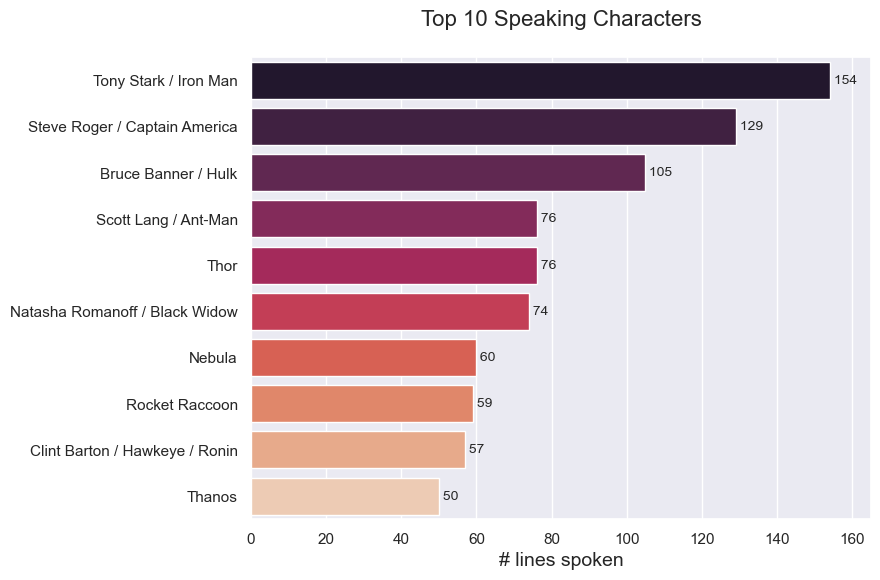

In [5]:
# extracting the top 10 speaking characters
top10spk = blocks_df['mapped_character'].value_counts().reset_index()[:10]

# initiate plot
plt.figure(figsize=(8, 6))
spk_plot = sns.barplot(x='count', y='mapped_character', data=top10spk, palette='rocket')
for i,v in enumerate(top10spk['count']):
    plt.text(v, i, ' '+str(v), va='center', fontsize=10)  # va='center' centers the text vertically

# plot
plt.title('Top 10 Speaking Characters\n', fontsize=16)
plt.xlabel('# lines spoken', fontsize=14)
plt.xlim(0,165)
plt.ylabel('')
plt.show()

The bar plot shows that Tony Stark has the most lines in the movie, which is expected since he’s the central figure in the Marvel Cinematic Universe (MCU). However, what's surprising is that the highest number of lines spoken is only 154, which seems relatively low for a movie that runs over three hours. This could be due to *Avengers: Endgame* being the final movie in the saga, featuring characters from dozens of MCU films with different leads. As a result, the dialogue is more evenly distributed among characters to appeal to millions of MCU fans.

Another notable observation is that Scott Lang/Ant-Man has as many lines as Thor and even more than Black Widow and Hawkeye, two of the original six Avengers, despite his character being introduced later in the series. This could be attributed to Ant-Man’s rising popularity among fans.

The next step is to analyze the top 5 most spoken words for each of the top characters. I'll begin by cleaning the text to remove unnecessary words or characters.

First, I'll remove stopwords. Stopwords are commonly used words in any language, such as "the," "is," and "and," which don’t add much meaning. The list of stopwords can vary depending on the context, but for this case, I'll use the stopwords provided by the `wordcloud` module.

Second, I’ll remove non-alphanumeric characters. This means getting rid of anything except for lowercase and uppercase letters, numbers, and the single quote (`'`) character.

Lastly, I'll apply lemmatization, which involves reducing different forms of a word to a single base form. For example, words like "know," "knows," and "knowing" will be reduced to "know," as they all convey the same meaning.

In [31]:
sw = set(STOPWORDS) # defining the stopwords
wnl = WordNetLemmatizer() # defining the lemmatization instance
def preprocess(text): # preprocessing function
    text = text.lower() # lowercasing
    text = re.sub(r'[^a-zA-Z0-9\s\']', ' ',text) # non-alphanumeric character removal 
    words = text.split()  # Split the text into words
    filtered_words = [wnl.lemmatize(re.sub(r'[^a-zA-Z0-9\s]', '',word.strip()),pos='v') for word in words if word.strip() not in sw] # sw removal and lemmatization
    return filtered_words

blocks_df['cleaned_line'] = blocks_df['line'].apply(preprocess)
blocks_df.head()

,character,mapped_character,line,cleaned_line
0,CLINT BARTON,Clint Barton / Hawkeye / Ronin,"Okay, you see where you're going? Le...","[okay, see, go, work]"
1,CLINT BARTON,Clint Barton / Hawkeye / Ronin,"Okay, good...tip down...bow arm out....","[okay, good, tip, bow, arm, three, finger]"
2,LILA BARTON,Lila barton,Why three?,[three]
3,CLINT BARTON,Clint Barton / Hawkeye / Ronin,`Cause two's not enough and four's t...,"[cause, twos, enough, fours, much]"
4,LAURA BARTON,Laura barton,"You guys want mustard or mayo, or both?","[guy, want, mustard, mayo]"


Determining the top 5 words spoken by each character.

In [32]:
word_count = {}

for index, row in blocks_df.iterrows():
    char = row['mapped_character']
    word = row['cleaned_line']
    
    if char not in word_count:
        word_count[char] = Counter()    
    word_count[char].update(word)

top5words = {character: words.most_common(5) for character, words in word_count.items()} # a dictionary of caharcters and words spoken 

Turn the dictionary into a dataframe

In [33]:
data = []
for char, words in top5words.items():
    for word, count in words:
        data.append([char, word, count])
plot_data = pd.DataFrame(data, columns=["Character", "Word", "Count"])
plot_data.head(10)

,Character,Word,Count
0,Clint Barton / Hawkeye / Ronin,know,8
1,Clint Barton / Hawkeye / Ronin,okay,4
2,Clint Barton / Hawkeye / Ronin,get,4
3,Clint Barton / Hawkeye / Ronin,go,3
4,Clint Barton / Hawkeye / Ronin,work,3
5,Lila barton,three,1
6,Lila barton,put,1
7,Lila barton,mayo,1
8,Lila barton,hot,1
9,Lila barton,dog,1


Filter the data for the top 10 characters

In [34]:
top10char = plot_data[plot_data['Character'].isin(top10spk['mapped_character'])]
top10char.head(10)

,Character,Word,Count
0,Clint Barton / Hawkeye / Ronin,know,8
1,Clint Barton / Hawkeye / Ronin,okay,4
2,Clint Barton / Hawkeye / Ronin,get,4
3,Clint Barton / Hawkeye / Ronin,go,3
4,Clint Barton / Hawkeye / Ronin,work,3
15,Tony Stark / Iron Man,know,20
16,Tony Stark / Iron Man,go,18
17,Tony Stark / Iron Man,time,15
18,Tony Stark / Iron Man,right,13
19,Tony Stark / Iron Man,get,12


now i will visualize the data to multiple barplots

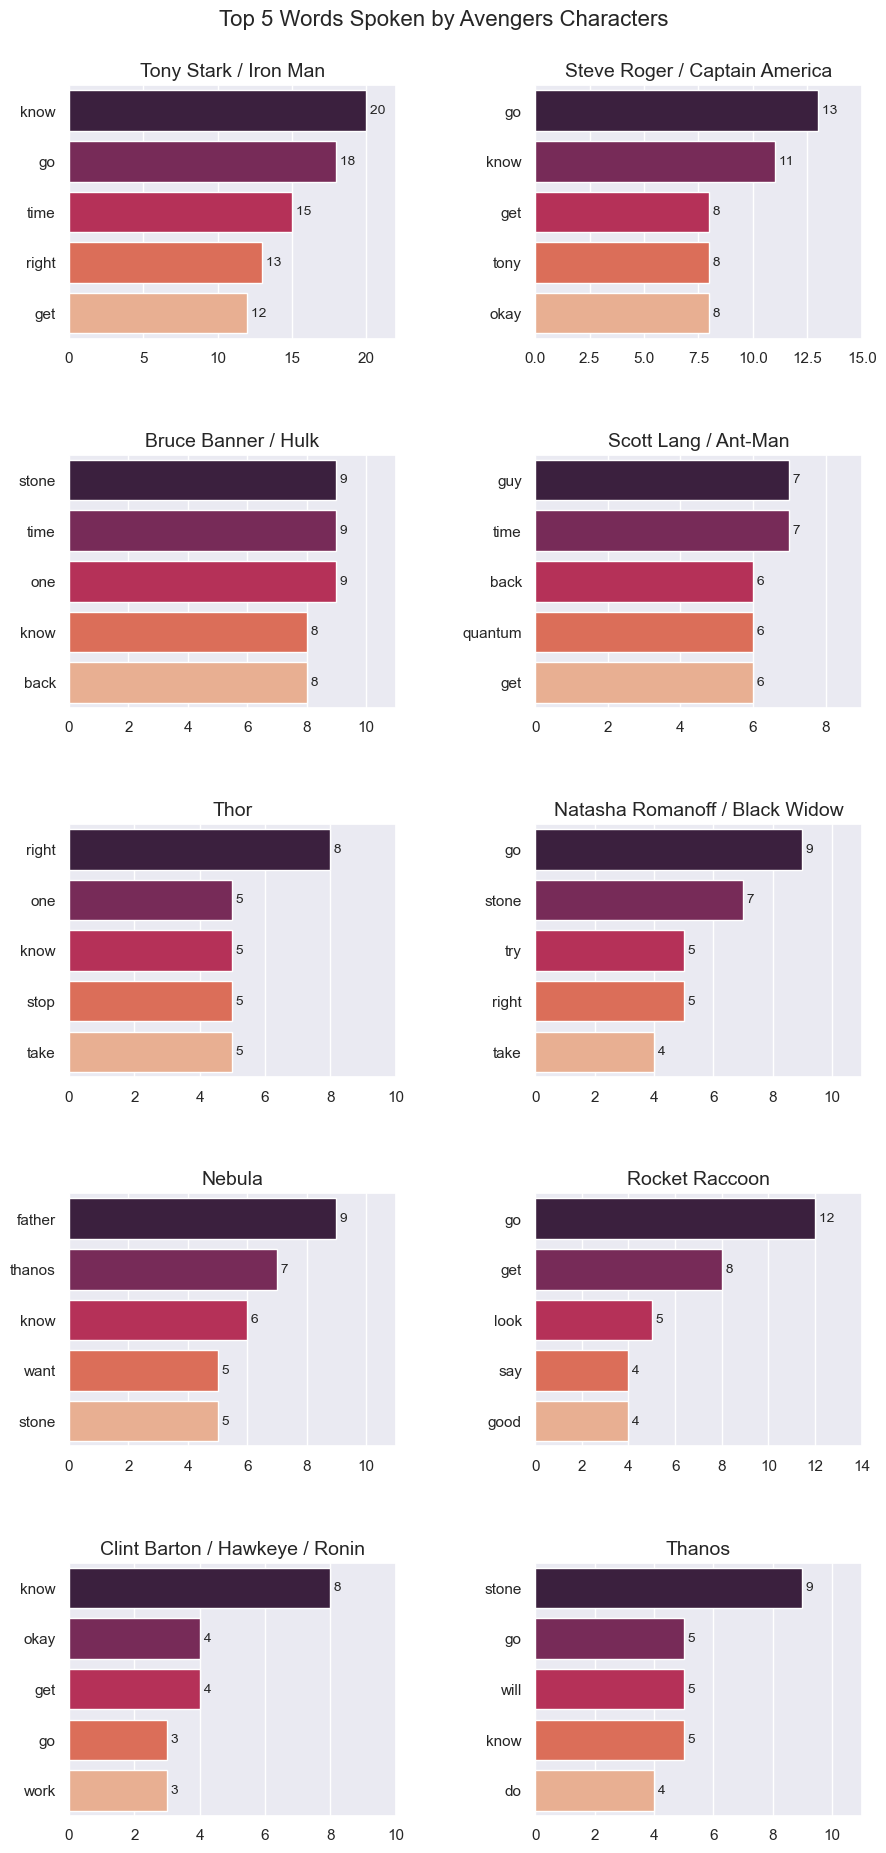

In [19]:
fig, axes = plt.subplots(5, 2, figsize=(10, 20))  # 2 rows, 5 columns
axes = axes.flatten()  # Flatten the axes array to iterate over


for i, top in enumerate(top10spk['mapped_character']):
    dt = top10char[top10char['Character'] == top]
    
    sns.barplot(x='Count', y='Word', data=dt, palette='rocket', ax=axes[i])
    
    # Add count labels to the bars
    for j, v in enumerate(dt['Count']):
        axes[i].text(v, j, ' '+str(v), va='center', fontsize=10)
    
    # Set titles and labels
    axes[i].set_title(top, fontsize=14)
    axes[i].set_xlabel('')
    axes[i].set_xlim(0,dt['Count'].max()+2)
    axes[i].set_ylabel('')

# Adjust layout to prevent overlap
plt.suptitle('Top 5 Words Spoken by Avengers Characters', fontsize=16, y=.95)
plt.tight_layout(pad=4)
plt.show()

Here are some insights from the plots:
- The word "know" is frequently spoken by most of the top 10 characters. This could be because it's a common word used in communication or because the movie contains a lot of exposition. Some might argue that "know" should have been considered a stop word and removed. This highlights the importance of how we define stop words during the cleaning process.
- The word "stone" is mentioned by many characters, emphasizing its significance in the plot. This could be seen as a use of a MacGuffin—a plot device that drives the story and characters' motivations but is, in itself, unimportant or irrelevant.
- The frequent mention of the word "time" reflects the central theme of time travel in the movie.
- There are instances of inter-character referencing, such as Steve Rogers mentioning Tony [Stark] multiple times, indicating Tony's significance in Steve's dialogue. Similarly, Nebula mentions "father" and "Thanos" (who is her father) frequently, highlighting Thanos' importance in her character arc and the plot.

# Bonus
Character Word Clouds

FileNotFoundError: [Errno 2] No such file or directory: 'img1.jpg'

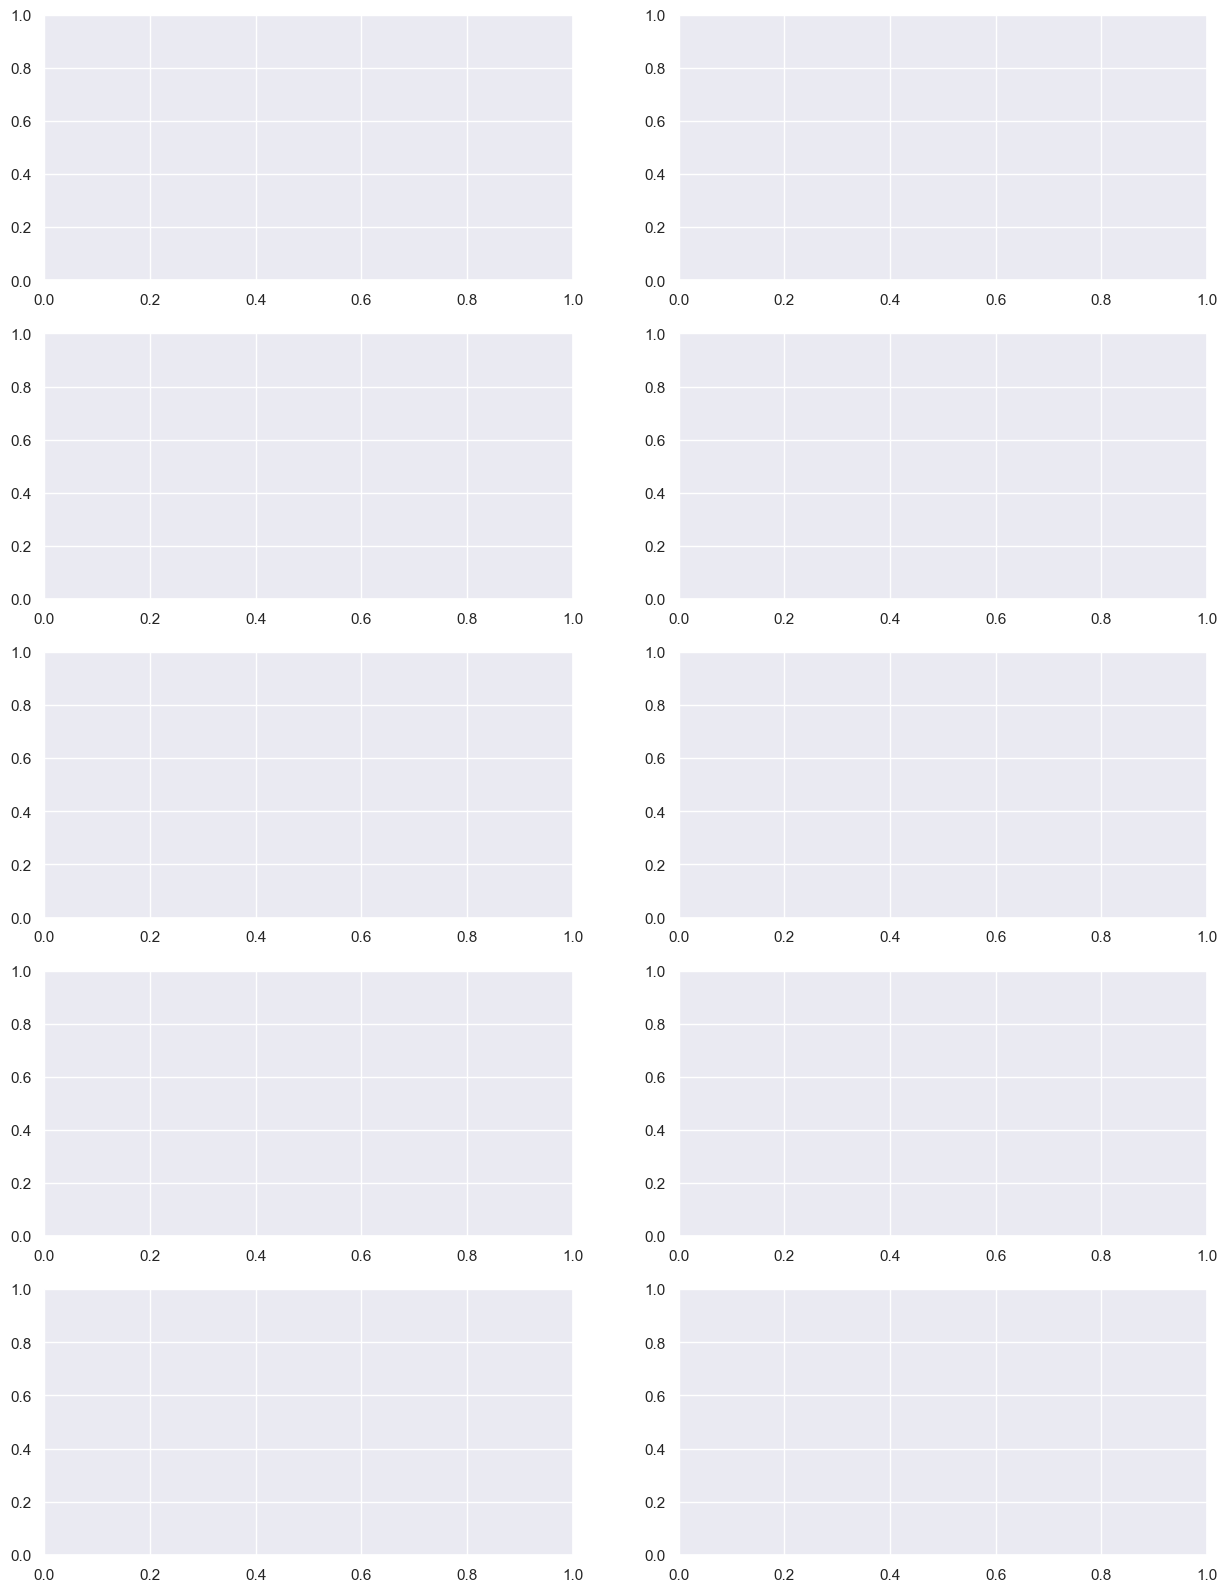

In [35]:
# Filtered word counts for the top 10 characters
filtered_word_counts = {char: word_count[char] for char in top10spk['mapped_character']}

# Function to ensure words are black
def black(word, font_size, position, orientation, random_state=None, **kwargs):
    return "rgb(0, 0, 0)"  # Black color in RGB

fig, axes = plt.subplots(5, 2, figsize=(15, 20))  # 5 rows, 2 columns
axes = axes.flatten()  # Flatten the 2D array of axes to 1D for easy iteration

image_no = 1 # Image number for loading masks

# Loop through each character and their word count data
for i, (character, counts) in enumerate(filtered_word_counts.items()):
    # Load the mask for the word cloud (assuming the mask image is named '1.jpg', '2.jpg', etc.)
    mask_image_path = 'img' + str(image_no) + '.jpg'
    msk = np.array(Image.open(mask_image_path))
    
    # Generate the word cloud with the mask and black words
    wordcloud = WordCloud(background_color='white', mask=msk, random_state=42).generate_from_frequencies(counts)
    
    # Plot the word cloud in the current subplot
    axes[i].imshow(msk, interpolation='bilinear')  # Display the mask in the background
    axes[i].imshow(wordcloud.recolor(color_func=black), interpolation='bilinear', alpha=0.15)  # Overlay the word cloud
    axes[i].set_title(f"{character}", fontsize=14)  # Set the title to the character's name
    axes[i].axis('off')  # Turn off the axis for a clean look
    
    image_no += 1 # Increment the image number for the next character's mask

plt.suptitle('Character Word Clouds', fontsize=20, y=1)
plt.tight_layout()
plt.show()